# Generating figures following Seurat analysis

In [ ]:
import scanpy as sc, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sb, bbknn
import rpy2.robjects as robjects
sc.settings.verbosity = 3
sb.set(style="whitegrid")

In [6]:
data = sc.read_h5ad("seurat_final.h5ad")
data

AnnData object with n_obs × n_vars = 52293 × 2000
    obs: 'predicted_doublet', 'doublet_score', 'patient', 'type', 'passage', 'disease', 'sex', 'batch', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'ribo_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.5', 'seurat_clusters', 'integrated_snn_res.0.8'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'SCT_features', 'integrated_features'
    obsm: 'X_umap'
    layers: 'SCT', 'integrated'

## Cluster composition dotplot

In [7]:
neo = ["903", "925", "930", "2016"]
child = ["896", "926", "938", "1048", "1092"]

In [24]:
data.obs.seurat_clusters = data.obs.seurat_clusters.astype("category")

df = pd.crosstab(data.obs['patient'],data.obs['seurat_clusters'], normalize='index')
df.index = df.index.astype(str)
df = df.reindex(neo+child)
df.head()

seurat_clusters,0,1,2,3,4,5,6,7,8,9,10,11,12
patient,,,,,,,,,,,,,
903,0.370241,0.330303,0.091608,0.027817,0.014452,0.061305,0.027739,0.025719,0.019814,0.007925,0.010256,0.012121,0.000699
925,0.408117,0.305761,0.044037,0.078434,0.011069,0.014401,0.025232,0.074506,0.009522,0.004523,0.007617,0.016782,0.000000
930,0.374325,0.326819,0.111376,0.051001,0.006673,0.018112,0.016047,0.034001,0.020972,0.010486,0.006991,0.023197,0.000000
2016,0.269917,0.435433,0.029767,0.017112,0.116480,0.031780,0.023008,0.009491,0.004458,0.014524,0.047023,0.001007,0.000000
896,0.207898,0.213516,0.230841,0.033713,0.061183,0.116279,0.035274,0.019510,0.023724,0.037303,0.009677,0.002966,0.008116


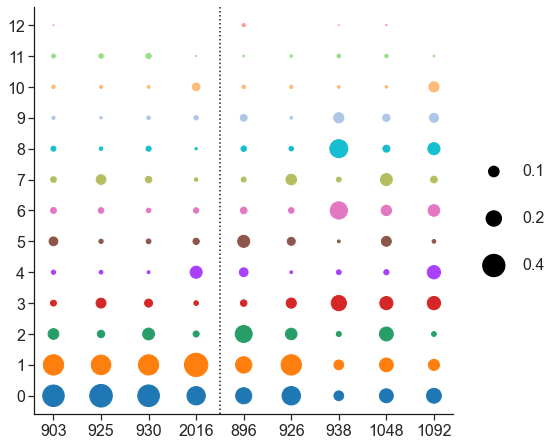

In [43]:
plt.rcParams["figure.figsize"] = (7.5,7.5)
df = pd.crosstab(data.obs['patient'],data.obs['seurat_clusters'], normalize='index')
df = df.reindex(neo+child)
min_val = np.inf
max_val = -np.inf
ax = plt.gca()
# ax.spines['right'].set_color('none')
# ax.spines['top'].set_color('none')
for c in df.columns:
    ax.scatter(df.index, [str(c) for i in range(9)], s=(df[c])*1250, c=data.uns["seurat_clusters_colors"][c])
    if min(df[c]) < min_val:
        min_val = min(df[c])
    if max(df[c]) > max_val:
        max_val = max(df[c])
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)

l1 = ax.scatter([],[], s=((max_val-min_val)/4)*1250, edgecolors='none', color='black', label=round((max_val-min_val)/4,1))
l1 = ax.scatter([],[], s=(max_val-min_val)/2*1250, edgecolors='none', color='black', label=round((max_val-min_val)/2,1))
l2 = ax.scatter([],[], s=max_val*1250, edgecolors='none', color='black', label=round(max_val,1))
ax.axvline(3.5, color="k",linestyle=":")
# ax.grid(False)
ax.legend(bbox_to_anchor=(1.025, 0.65), labelspacing=2, frameon=False, fontsize=16)
plt.show()

## UMAP plots

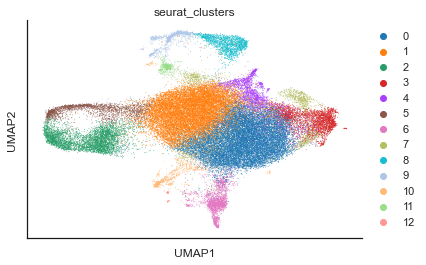

In [25]:
sc.pl.umap(data, color=["seurat_clusters"])

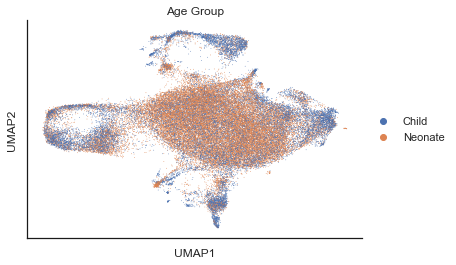

In [26]:
sc.pl.umap(data, color="type", show=False)
plt.title("Age Group")
plt.show()

## Cluster compositions barchart

In [27]:
import matplotlib
sb.set(style="whitegrid")
rc = {"axes.spines.left" : True,
      "axes.spines.right" : False,
      "axes.spines.bottom" : True,
      "axes.spines.top" : False,
      "xtick.bottom" : True,
      "xtick.labelbottom" : True,
      "ytick.labelleft" : True,
      "ytick.left" : True,
      "axes.grid" : False,
     "axes.edgecolor":"k"}
plt.rcParams.update(rc)

for k in rc.keys():
    plt.rcParams[k] = rc[k]

Text(0.5, 0, '')

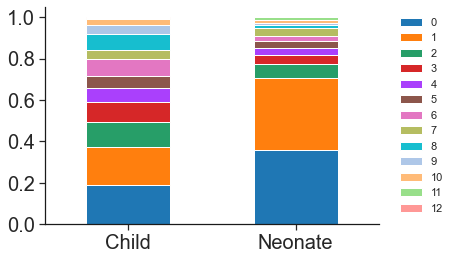

In [28]:
df = pd.crosstab(data.obs['batch'],data.obs['seurat_clusters'], normalize='index')
pd.crosstab(data.obs['type'],data.obs['seurat_clusters'], normalize='index')\
    .plot.bar(stacked=True, grid=False, capsize=4, color=data.uns["seurat_clusters_colors"], fontsize=20)\
    .legend(loc='right', bbox_to_anchor=(1.22, 0.5), frameon=False)
plt.xticks(rotation=0)
plt.xlabel("")

## Dotplots of selected gene expression

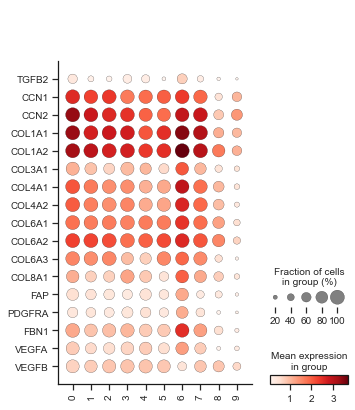

In [29]:
sc.pl.dotplot(data[data.obs.seurat_clusters.isin(range(0,10))], 
              var_names=["TGFB2", "CCN1", "CCN2", "COL1A1", "COL1A2", "COL3A1", 
                         "COL4A1", "COL4A2", "COL6A1", "COL6A2", "COL6A3", "COL8A1", 
                         "FAP", "PDGFRA", 'FBN1', "VEGFA", "VEGFB"],
              groupby="seurat_clusters", swap_axes=True, show=False)
plt.xticks(rotation=0)
plt.show()

## Differential expression plots
#### Load Seurat DE results

In [38]:
robjects.r['load']("./seurat_de.RData")

'clust.de.markers'


In [42]:
df = robjects.r['clust.de.markers']

In [ ]:
df = robjects.r['clust.de.markers']
# df.sort_values(by="avg_log2FC", ascending=False)
dfs = [df[df.cluster==str(i)] for i in range(0,13)]
for i in range(len(dfs)):
    dfs[i] = dfs[i].sort_values(by="avg_log2FC", ascending=False)

dfs[6]

In [ ]:
n=6
clust_markers = dfs[n]

fig = plt.figure(
    figsize=(
        4 * plt.rcParams['figure.figsize'][0],
        6 * plt.rcParams['figure.figsize'][1],
    )
)
gs = matplotlib.gridspec.GridSpec(nrows=6, ncols=4, wspace=0.22, hspace=0.3)
ax = fig.add_subplot(gs[0])
ax.set_ylim(np.min(0.95*clust_markers.avg_log2FC[:25]), np.max(clust_markers.avg_log2FC[:25])*1.1)
ax.set_xlim(0,26)
for ig, gene_name in enumerate(clust_markers.gene[:25].to_list()):
    ax.text(
        ig+1,
        clust_markers.avg_log2FC[ig],
        gene_name,
        rotation='vertical',
        verticalalignment='bottom',
        horizontalalignment='center',
        fontsize=12,
)
plt.xlabel("Rank")
plt.ylabel("Log Fold Change")
plt.title(f"Cluster {n} vs Rest")
plt.grid(None)
plt.show()

In [ ]:
n=4
clust_markers = dfs[n]

fig = plt.figure(
    figsize=(
        4 * plt.rcParams['figure.figsize'][0],
        6 * plt.rcParams['figure.figsize'][1],
    )
)
gs = matplotlib.gridspec.GridSpec(nrows=6, ncols=4, wspace=0.22, hspace=0.3)
ax = fig.add_subplot(gs[0])
ax.set_ylim(np.min(0.95*clust_markers.avg_log2FC[:25]), np.max(clust_markers.avg_log2FC[:25])*1.1)
ax.set_xlim(0,26)
for ig, gene_name in enumerate(clust_markers.gene[:25].to_list()):
    ax.text(
        ig+1,
        clust_markers.avg_log2FC[ig],
        gene_name,
        rotation='vertical',
        verticalalignment='bottom',
        horizontalalignment='center',
        fontsize=12,
)
plt.xlabel("Rank")
plt.ylabel("Log Fold Change")
plt.title(f"Cluster {n} vs Rest")
plt.grid(None)
plt.show()

#### Plot selected DE surface proteins

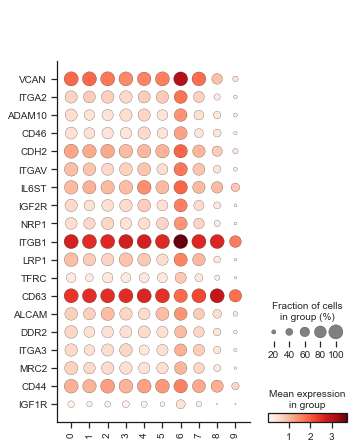

In [41]:
sc.pl.dotplot(data[data.obs.seurat_clusters.isin(range(0,10))], 
              var_names=['VCAN','ITGA2','ADAM10','CD46','CDH2','ITGAV','IL6ST','IGF2R','NRP1','ITGB1','LRP1','TFRC','CD63','ALCAM','DDR2','ITGA3','MRC2','CD44','IGF1R'],
              groupby="seurat_clusters", swap_axes=True, show=False)
plt.xticks(rotation=0)
plt.show()